In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [35]:

# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Leitura da base de população
populacao_path = '../data/populacao/br_ibge_populacao_municipio.csv'
populacao_df = pd.read_csv(populacao_path)

# Normalização de colunas
populacao_df.columns = populacao_df.columns.str.strip().str.lower()
populacao_df = populacao_df.rename(columns={'sigla_uf': 'UF', 'populacao': 'QUANT_POPULACAO'})
print(populacao_df)

         ano   UF  id_municipio  QUANT_POPULACAO
0       1991   RO     1100015.0          31981.0
1       1992   RO     1100015.0          34768.0
2       1993   RO     1100015.0          37036.0
3       1994   RO     1100015.0          39325.0
4       1995   RO     1100015.0          41574.0
...      ...  ...           ...              ...
174383  2019   DF     5300108.0        3015268.0
174384  2020   DF     5300108.0        3055149.0
174385  2021   DF     5300108.0        3094325.0
174386  2022   DF     5300108.0        2923369.0
174387  2011  NaN           NaN           8149.0

[174388 rows x 4 columns]


In [52]:
# Leitura da base de infrações
FOLDER = "../data/infracoes"
PREFIX = "infracoes_"
SUFFIX = ""
EXTENSION = "csv"

FILES = []
for y in range (2019, 2025):
    for m in range (1, 13):
        FILES.append(
            {
                "year": y,
                "month": m,
                "path": f'{FOLDER}/{PREFIX}{y}_{m:02d}{SUFFIX}.{EXTENSION}'
            }
        )

FILES

ENCODINGS = ['utf-8', 'utf-16']
SEPARATORS = [',', ';']
VARIATIONS = ['Codigo da Infracao', 'Codigo_Infracao', 'Cod _Infração', 'COD_INFRACAO']
CORRECT = "INFRACAO"

all_data = []

for file in FILES:
    for encoding in ENCODINGS:
        for separator in SEPARATORS:
            try:
                data = pd.read_csv(file["path"], sep=separator, encoding=encoding)
                
                if len(data.columns) == 1: # Wrong separator
                    continue

                if len(data.columns) > 3: # Each state in a column
                    data = data.drop(0)
                    data.rename(columns={data.columns[0]: CORRECT})
                    data.columns = [CORRECT] + list(data.columns[1:])
                    data = data.melt(id_vars=[CORRECT], var_name="UF", value_name="Quantidade")

                # Normalize columns
                data.columns = [unidecode(col).upper() for col in data.columns]
                for variation in VARIATIONS:
                    adjusted_variation = unidecode(variation).upper()
                    if adjusted_variation in data.columns:
                        data = data.rename(columns={adjusted_variation: CORRECT})
                        break
                data = data[['UF', CORRECT, 'QUANTIDADE']]

                # Adjust numbers
                data['QUANTIDADE'] = data['QUANTIDADE'].fillna(0)
                data['QUANTIDADE'] = data['QUANTIDADE'].astype(str).str.replace('.', '', regex=False).astype(int)

                # Add time identifiers
                data['MES'] = file['month']
                data['ANO'] = file['year']                    
                all_data.append(data)

                break
            except UnicodeError: # Wrong encoding
                continue

# Concatenar as infrações
infracoes_df = pd.concat(all_data)
infracoes_df.head()
print(infracoes_df)

# Normalizar colunas de infrações
infracoes_df.columns = [unidecode(col).upper() for col in infracoes_df.columns]
infracoes_df.rename(columns={'CODIGO_DA_INFRACAO': 'INFRACAO'}, inplace=True)

# Agregar as infrações por município
infracoes_aggregated = infracoes_df.groupby('UF').agg({'QUANTIDADE': 'sum'}).reset_index()
infracoes_aggregated = infracoes_aggregated.rename(columns={'UF': 'nome_uf', 'total': 'TOTAL'})
print(infracoes_aggregated)

             UF INFRACAO  QUANTIDADE  MES   ANO
0          ACRE     5002          15    1  2019
1          ACRE     5010         827    1  2019
2          ACRE     5029          12    1  2019
3          ACRE     5037          48    1  2019
4          ACRE     5045         514    1  2019
...         ...      ...         ...  ...   ...
6961  TOCANTINS     7773           0   12  2024
6962  TOCANTINS     7781           0   12  2024
6963  TOCANTINS     7790           0   12  2024
6964  TOCANTINS     7803           2   12  2024
6965  TOCANTINS     7811           0   12  2024

[365553 rows x 5 columns]
                nome_uf  QUANTIDADE
0                  ACRE      721756
1               ALAGOAS     2595742
2                 AMAPA      672910
3              AMAZONAS     2755769
4                 BAHIA    14386137
5                 CEARA    15488089
6      DISTRITO FEDERAL    14291214
7        ESPIRITO SANTO     5828208
8                 GOIAS    20861383
9              MARANHAO     3631580
1

In [25]:
# Leitura da base de frotas
FOLDER = "../data/frota"
PREFIX = "frota_"
SUFFIX = ""
EXTENSION = "xls"

FILES = []
for i in range (2004, 2025):
    FILES.append(
        {
            "year": i,
            "path": f'{FOLDER}/{PREFIX}{i}{SUFFIX}.{EXTENSION}'
        }
    )

FILES

all_data = []
previous = []

for file in FILES:    
    excel_file = pd.ExcelFile(file['path'])
    data = pd.read_excel(file['path'], sheet_name=excel_file.sheet_names[-1], skiprows=3, header=0)

    data.columns = (
        data.columns.str.normalize('NFKD')  # Decompose unicode characters
        .str.encode('ascii', errors='ignore')  # Remove non-ASCII characters
        .str.decode('utf-8')  # Decode back to UTF-8
        .str.strip()  # Remove leading/trailing spaces
        .str.lower()  # Convert to lowercase
    )

    data['ano'] = file['year']

    all_data.append(data)

# Concatenar as frotas
frotas_df = pd.concat(all_data)
# Agregar a frota por município
frotas_aggregated = frotas_df.groupby('uf').agg({'total': 'sum'}).reset_index()
print(frotas_aggregated)
frotas_aggregated = frotas_aggregated.rename(columns={'uf': 'UF', 'total': 'TOTAL'})


    uf        total
0   AC    4501578.0
1   AL   13790321.0
2   AM   15087259.0
3   AP    3252141.0
4   BA   68154238.0
5   CE   51060876.0
6   DF   31749448.0
7   ES   33534284.0
8   GO   66596151.0
9   MA   26484879.0
10  MG  190963777.0
11  MS   26829383.0
12  MT   34788105.0
13  PA   32174904.0
14  PB   21010311.0
15  PE   50227496.0
16  PI   18714919.0
17  PR  133381250.0
18  RJ  117569273.0
19  RN   21118153.0
20  RO   16164077.0
21  RR    3617971.0
22  RS  124395372.0
23  SC   89992280.0
24  SE   12653782.0
25  SP  515576326.0
26  TO   11499955.0


In [43]:
print(populacao_df['UF'].unique())
print(frotas_aggregated['UF'].unique())
print(infracoes_aggregated['UF'].unique())

['RO' 'AC' 'AM' 'RR' 'PA' 'AP' 'TO' 'MA' 'PI' 'CE' 'RN' 'PB' 'PE' 'AL'
 'SE' 'BA' 'MG' 'ES' 'RJ' 'SP' 'PR' 'SC' 'RS' 'MS' 'MT' 'GO' 'DF' nan]
['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RN' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']
['ACRE' 'ALAGOAS' 'AMAPA' 'AMAZONAS' 'BAHIA' 'CEARA' 'DISTRITO FEDERAL'
 'ESPIRITO SANTO' 'GOIAS' 'MARANHAO' 'MATO GROSSO' 'MATO GROSSO DO SUL'
 'MINAS GERAIS' 'PARA' 'PARAIBA' 'PARANA' 'PERNAMBUCO' 'PIAUI'
 'RIO DE JANEIRO' 'RIO GRANDE DO NORTE' 'RIO GRANDE DO SUL' 'RONDONIA'
 'RORAIMA' 'SANTA CATARINA' 'SAO PAULO' 'SERGIPE' 'TOCANTINS']


In [ ]:
uf_mapping = {
    'AC': 'ACRE',
    'AL': 'ALAGOAS',
    'AM': 'AMAPA',
    'AP': 'AP',
    'BA': 'BAHIA',
    'CE': 'CEARA',
    'DF': 'DISTRITO FEDERAL',
    'ES': 'ESPIRITO SANTO',
    'GO': 'GOIAS',
    'MA': 'MARANHAO',
    'MG': 'MINAS GERAIS',
    'MS': 'MATO GROSSO DO SUL',
    'MT': 'MATO GROSSO',
    'PA': 'PARA',
    'PB': 'PARAIBA',
    'PE': 'PERNAMBUCO',
    'PI': 'PIAUI',
    'PR': 'PARANA',
    'RJ': 'RIO DE JANEIRO',
    'RN': 'RIO GRANDE DO NORTE',
    'RO': 'RONDONIA',
    'RR': 'RORAIMA',
    'RS': 'RIO GRANDE DO SUL',
    'SC': 'SANTA CATARINA',
    'SE': 'SERGIPE',
    'SP': 'SAO PAULO',
    'TO': 'TOCANTINS'
}

populacao_df['nome_uf'] = populacao_df['UF'].map(uf_mapping)
frotas_aggregated['nome_uf'] = frotas_aggregated['UF'].map(uf_mapping)
frotas_aggregated['nome_uf'] = frotas_aggregated['UF'].map(uf_mapping)
print(populacao_df)
print(frotas_aggregated)

         ano   UF  id_municipio  QUANT_POPULACAO           nome_uf
0       1991   RO     1100015.0          31981.0          RONDONIA
1       1992   RO     1100015.0          34768.0          RONDONIA
2       1993   RO     1100015.0          37036.0          RONDONIA
3       1994   RO     1100015.0          39325.0          RONDONIA
4       1995   RO     1100015.0          41574.0          RONDONIA
...      ...  ...           ...              ...               ...
174383  2019   DF     5300108.0        3015268.0  DISTRITO FEDERAL
174384  2020   DF     5300108.0        3055149.0  DISTRITO FEDERAL
174385  2021   DF     5300108.0        3094325.0  DISTRITO FEDERAL
174386  2022   DF     5300108.0        2923369.0  DISTRITO FEDERAL
174387  2011  NaN           NaN           8149.0               NaN

[174388 rows x 5 columns]
    UF        TOTAL              nome_uf
0   AC    4501578.0                 ACRE
1   AL   13790321.0              ALAGOAS
2   AM   15087259.0                AMAPA
3   A

In [60]:
# Merge das três bases
merged_data = pd.merge(populacao_df, frotas_aggregated, on='nome_uf', how='inner')
merged_data = pd.merge(merged_data, infracoes_aggregated, on='nome_uf', how='inner')
print(merged_data)

# Renomear colunas para facilitar análise
merged_data.rename(columns={'POPULACAO': 'POPULACAO', 'QUANTIDADE': 'TOTAL_INFRACOES'}, inplace=True)

         ano UF_x  id_municipio  QUANT_POPULACAO           nome_uf UF_y  \
0       1991   RO     1100015.0          31981.0          RONDONIA   RO   
1       1992   RO     1100015.0          34768.0          RONDONIA   RO   
2       1993   RO     1100015.0          37036.0          RONDONIA   RO   
3       1994   RO     1100015.0          39325.0          RONDONIA   RO   
4       1995   RO     1100015.0          41574.0          RONDONIA   RO   
...      ...  ...           ...              ...               ...  ...   
173881  2018   DF     5300108.0        2974703.0  DISTRITO FEDERAL   DF   
173882  2019   DF     5300108.0        3015268.0  DISTRITO FEDERAL   DF   
173883  2020   DF     5300108.0        3055149.0  DISTRITO FEDERAL   DF   
173884  2021   DF     5300108.0        3094325.0  DISTRITO FEDERAL   DF   
173885  2022   DF     5300108.0        2923369.0  DISTRITO FEDERAL   DF   

             TOTAL  QUANTIDADE  
0       16164077.0     1817031  
1       16164077.0     1817031  


In [75]:
# Renomear colunas para facilitar análise
merged_data.rename(columns={'QUANT_POPULACAO': 'populacao', 'TOTAL': 'total_veiculos', 'TOTAL_INFRACOES': 'total_infracoes'}, inplace=True)

In [76]:
# Print para verificar a estrutura dos dados
print(merged_data.head())

    ano UF_x  id_municipio  populacao   nome_uf UF_y  total_veiculos  \
0  1991   RO     1100015.0    31981.0  RONDONIA   RO      16164077.0   
1  1992   RO     1100015.0    34768.0  RONDONIA   RO      16164077.0   
2  1993   RO     1100015.0    37036.0  RONDONIA   RO      16164077.0   
3  1994   RO     1100015.0    39325.0  RONDONIA   RO      16164077.0   
4  1995   RO     1100015.0    41574.0  RONDONIA   RO      16164077.0   

   total_infracoes  
0          1817031  
1          1817031  
2          1817031  
3          1817031  
4          1817031  


In [77]:
# Análise da relação entre a quantidade de veículos, população e infrações
X = merged_data[['populacao', 'total_infracoes']]
y = merged_data['total_veiculos']

In [78]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento do modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação do modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 66760025.12088326
R² Score: 0.9999999970537499


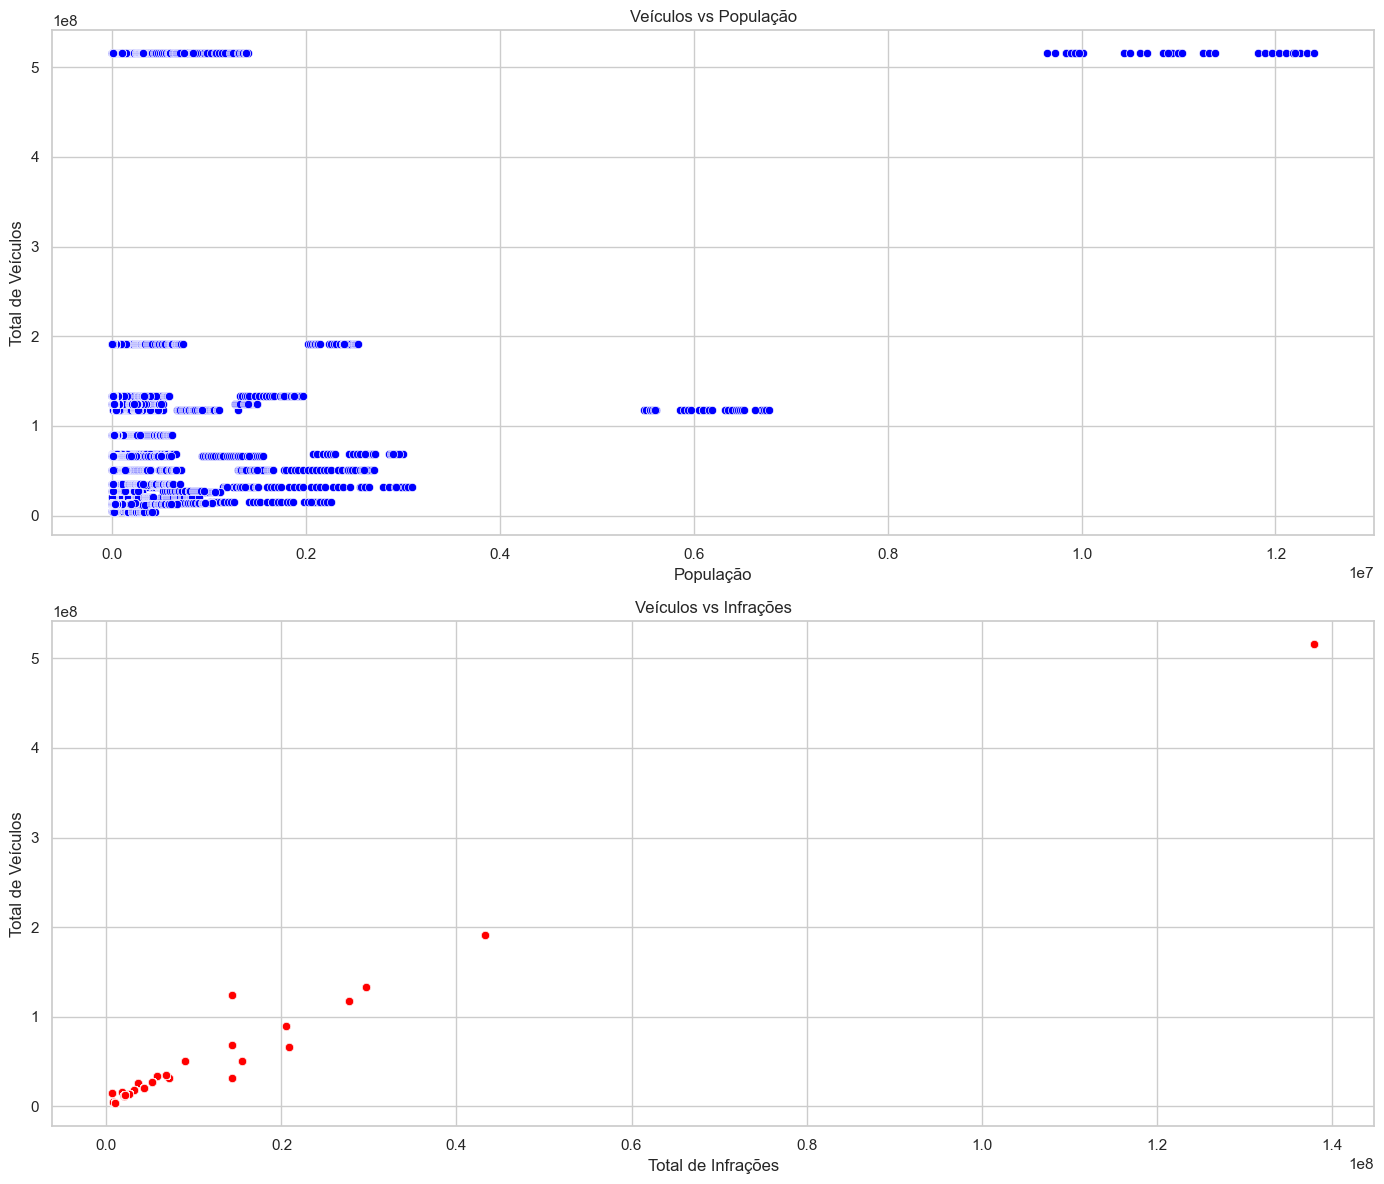

In [79]:
# Visualização da relação em gráficos separados
plt.figure(figsize=(14, 12))

# Gráfico 1: Veículos vs População
plt.subplot(2, 1, 1)
sns.scatterplot(data=merged_data, x='populacao', y='total_veiculos', color='blue')
plt.title('Veículos vs População')
plt.xlabel('População')
plt.ylabel('Total de Veículos')

# Gráfico 2: Veículos vs Infrações
plt.subplot(2, 1, 2)
sns.scatterplot(data=merged_data, x='total_infracoes', y='total_veiculos', color='red')
plt.title('Veículos vs Infrações')
plt.xlabel('Total de Infrações')
plt.ylabel('Total de Veículos')

plt.tight_layout()
plt.show()

1. Gráfico de Dispersão: Relação entre População, Infrações e Total de Veículos por UF

Interpretação:
Eixo X (População e Total de Infrações): O eixo x contém informações sobre a população dos municípios e a quantidade total de infrações. A presença de dois conjuntos de pontos (azul e vermelho) indica que a população e as infrações estão sendo comparadas em relação ao total de veículos.
Eixo Y (Total de Veículos): O eixo y mostra o total de veículos registrados por UF.

Pontos Azuis (Veículos vs População): Representam a relação entre a população e o total de veículos. Um aumento na população geralmente leva a um aumento no número de veículos, embora a relação não seja linear.
Pontos Vermelhos (Veículos vs Infrações): Representam a relação entre o total de infrações e o total de veículos. O gráfico sugere que um aumento nas infrações também está associado a um aumento no número de veículos, mas a dispersão é maior, indicando variabilidade.

Relação com a Base:
A análise sugere que, em geral, tanto a população quanto a quantidade de infrações têm uma correlação positiva com o total de veículos. No entanto, a presença de outliers (pontos distantes) pode afetar a interpretação.

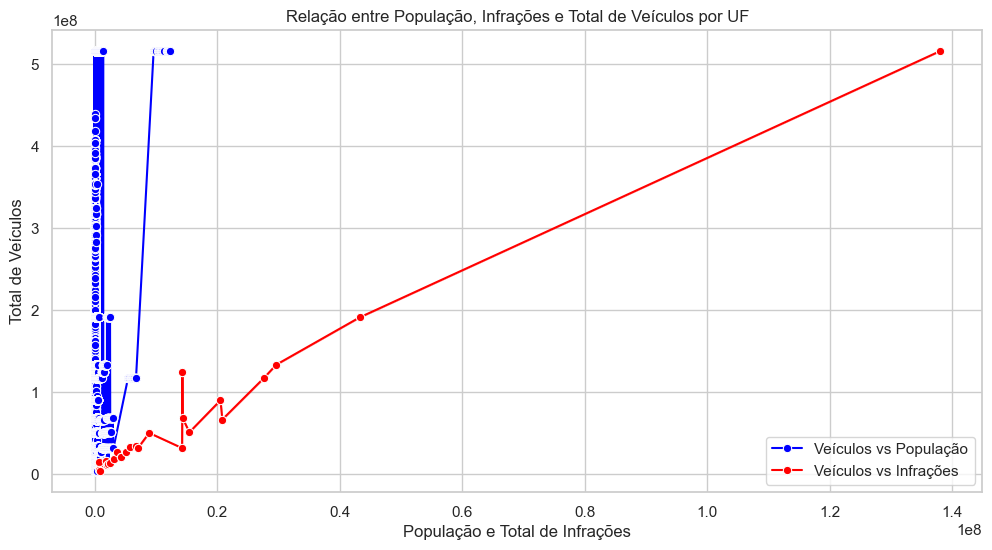

In [80]:
# Gráfico de linhas para visualizar tendências ao longo do tempo (se aplicável)
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_data, x='populacao', y='total_veiculos', label='Veículos vs População', color='blue', marker='o')
sns.lineplot(data=merged_data, x='total_infracoes', y='total_veiculos', label='Veículos vs Infrações', color='red', marker='o')
plt.title('Relação entre População, Infrações e Total de Veículos por UF')
plt.xlabel('População e Total de Infrações')
plt.ylabel('Total de Veículos')
plt.legend()
plt.show()

2. Gráfico de Pares: Relações entre População, Infrações e Total de Veículos

Interpretação:
Este gráfico permite visualizar todas as combinações de relações entre as variáveis populacao, total_infracoes e total_veiculos.
As diagonais mostram a distribuição de cada variável, enquanto as áreas abaixo da diagonal mostram a relação entre as variáveis.
A presença de muitos pontos agrupados em certas áreas sugere que há uma concentração de valores semelhantes, enquanto áreas com poucos pontos indicam menos ocorrências.

Relação com a Base:
O gráfico de pares é útil para identificar padrões e outliers nas variáveis. A correlação entre a população e o total de veículos parece ser mais forte, enquanto a relação entre infrações e veículos mostra uma dispersão maior, indicando que outras variáveis podem estar influenciando essa relação

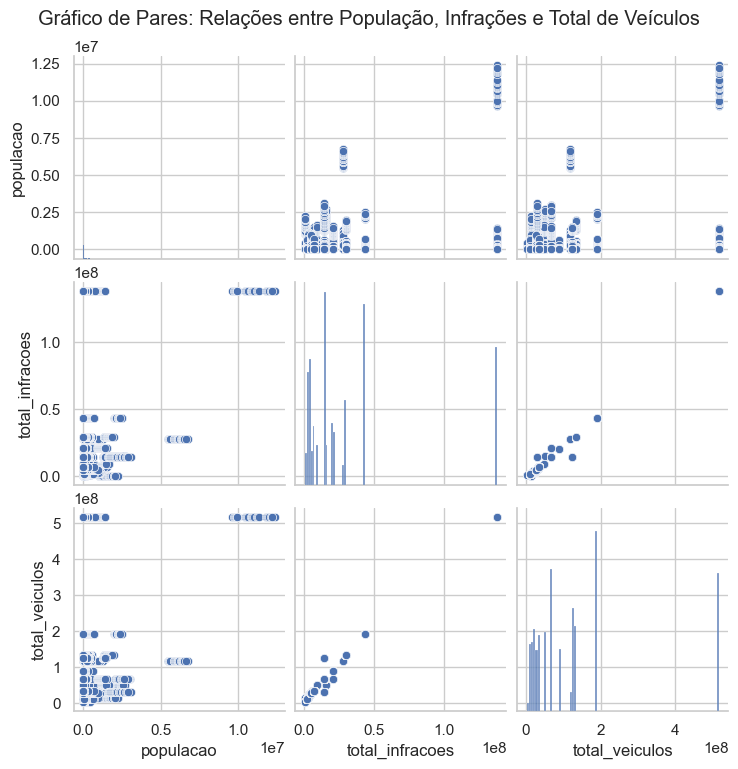

In [81]:
# Gráfico de pares para visualizar todas as relações
sns.pairplot(merged_data[['populacao', 'total_infracoes', 'total_veiculos']])
plt.suptitle('Gráfico de Pares: Relações entre População, Infrações e Total de Veículos', y=1.02)
plt.show()

3. Gráficos de Dispersão Separados: Veículos vs População e Veículos vs Infrações

Interpretação:
Gráfico 1 (Veículos vs População): Mostra uma forte relação entre o total de veículos e a população. O aumento da população está associado a um aumento no total de veículos, mas a relação não é perfeitamente linear, indicando que outros fatores também podem estar em jogo.
Gráfico 2 (Veículos vs Infrações): A relação entre infrações e veículos é menos clara. Embora haja uma tendência de aumento, a dispersão dos dados sugere que o total de veículos não depende apenas do número de infrações. Há muitos pontos com infrações baixas mas um total de veículos elevado.

Relação com a Base:
Esses gráficos ajudam a visualizar como as variáveis se comportam individualmente em relação ao total de veículos. Eles mostram que, enquanto a população é um bom indicador do total de veículos, a quantidade de infrações não é tão previsível, indicando que outras variáveis externas podem estar influenciando essas relações.